In [ ]:
# 1. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Setup
import os #os: For file and directory operations.
from PIL import Image, ImageFile #PIL: Python Imaging Library to handle images.
ImageFile.LOAD_TRUNCATED_IMAGES = True  #Prevents crashes when loading incomplete or corrupted images.

# Define paths for training and validation image folders stored in Drive.
train_dir = '/content/drive/MyDrive/Dataset/train'
val_dir = '/content/drive/MyDrive/Dataset/val'

# 3. Convert to RGB Checks if each image is in RGB mode. If not, it converts and saves it back. Catches and logs any error.
def convert_images_to_rgb(directory):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(root, filename)
                try:
                    with Image.open(filepath) as img:
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                            img.save(filepath)
                            print(f"Converted: {filepath}")
                except Exception as e:
                    print(f"Failed to process {filepath}: {e}")

#Applies the function to both training and validation datasets.
convert_images_to_rgb(train_dir)
convert_images_to_rgb(val_dir)

# 4. Remove corrupted images. This function: Verifies that each image is loadable. If not, it prints the error and removes the file.
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, filename)
                try:
                    with Image.open(path) as img:
                        img.verify()
                except Exception as e:
                    print(f"Removing corrupted: {path} — {e}")
                    os.remove(path)

#Cleans both train and validation sets from corrupted images.
remove_corrupted_images(train_dir)
remove_corrupted_images(val_dir)

# 5. Data generators. Sets up image size and batch size for training. ImageDataGenerator: A utility that loads images with optional augmentation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224) #MobileNetV2, like many pretrained CNNs (e.g., VGG, ResNet), is trained on ImageNet, which uses images of size 224×224 pixels.
batch_size = 32 #This is the number of images processed together in one step during training. 32 is a commonly used default batch size because:
#It provides a good trade-off between training speed and model accuracy. It fits well in memory for most GPUs/CPUs. It speeds up training by using vectorized operations on batch

#Train generator: Applies rescaling, zoom, and horizontal flip. Val generator: Only rescaling.
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

#Reads and prepares batches of images from directories. class_mode='categorical': Required for multi-class classification.
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# 6. Model setup. Import MobileNetV2 and layers to build a neural network.
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

#Load pre-trained MobileNetV2 (excluding top layers). Freeze it (do not train base layers).
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

#Build your final model: MobileNetV2 (as feature extractor). Global Average Pooling (reduces dimensions)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'), #Dense layer (128 units)
    layers.Dropout(0.3), #Dropout (30%) to prevent overfitting
    layers.Dense(2, activation='softmax')  #Output layer with 2 neurons and softmax (for 2-class classification)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Compiles the model with Adam optimizer. Uses categorical cross-entropy for multi-class classification.
model.summary() #Shows model summary

# 7. Train the model using the data generators for 5 epochs. Returns training history (accuracy/loss).

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)
# 8. Save model
model.save('waste_classifier.keras')


Mounted at /content/drive
Found 14165 images belonging to 2 classes.
Found 1201 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.9516 - loss: 0.1305 - val_accuracy: 0.9550 - val_loss: 0.1218
Epoch 2/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.9862 - loss: 0.0377 - val_accuracy: 0.9459 - val_loss: 0.1242
Epoch 3/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 1019s 2s/step - accuracy: 0.9866 - loss: 0.0347 - val_accuracy: 0.9492 - val_loss: 0.1420
Epoch 4/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 992s 2s/step - accuracy: 0.9895 - loss: 0.0267 - val_accuracy: 0.9600 - val_loss: 0.1140
Epoch 5/5
443/443 ━━━━━━━━━━━━━━━━━━━━ 1010s 2s/step - accuracy: 0.9907 - loss: 0.0243 - val_accuracy: 0.9592 - val_loss: 0.1384


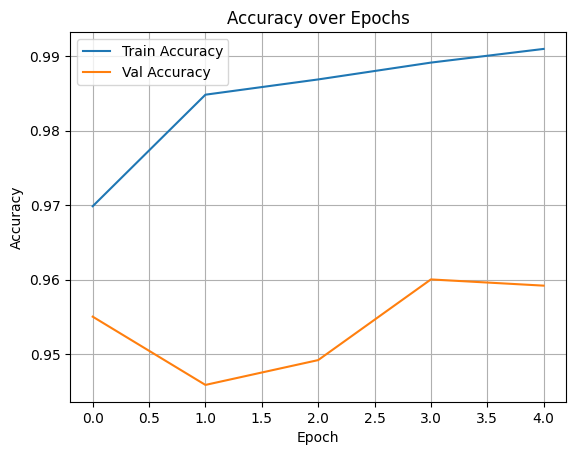

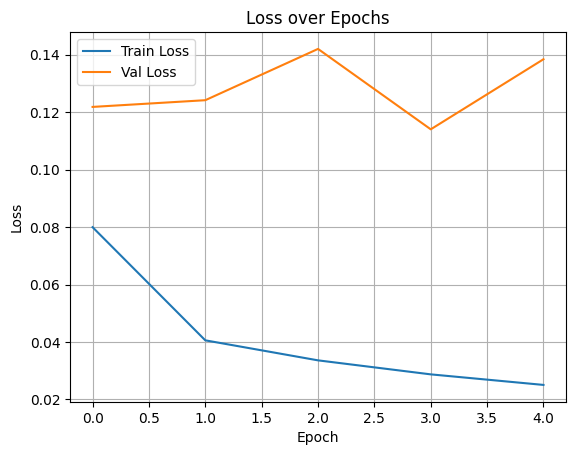

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Gap between train and val loss	Indicates possible overfitting — the model learns the training data but struggles with generalization.

Solution:

Adding early stopping and model checkpointing

Applying data augmentation in a better way

38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step
Classification Report:
                   precision    recall  f1-score   support

    biodegradable       0.73      0.74      0.74       894
non_biodegradable       0.22      0.21      0.21       307

         accuracy                           0.61      1201
        macro avg       0.47      0.48      0.48      1201
     weighted avg       0.60      0.61      0.60      1201



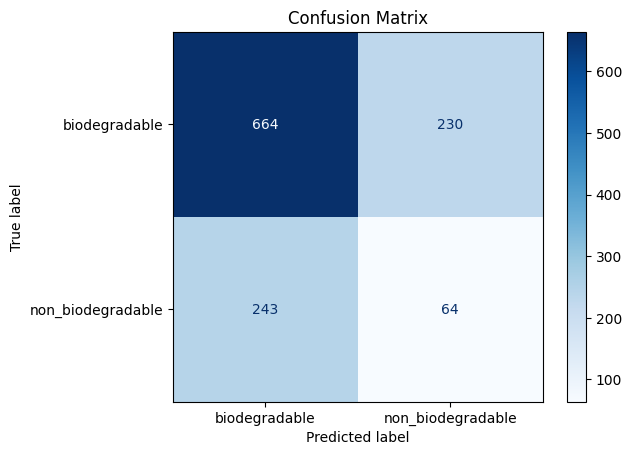

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


This shows:

High accuracy for biodegradable but poor for non-biodegradable.

Class imbalance or insufficient learning for class 1 (non-biodegradable).


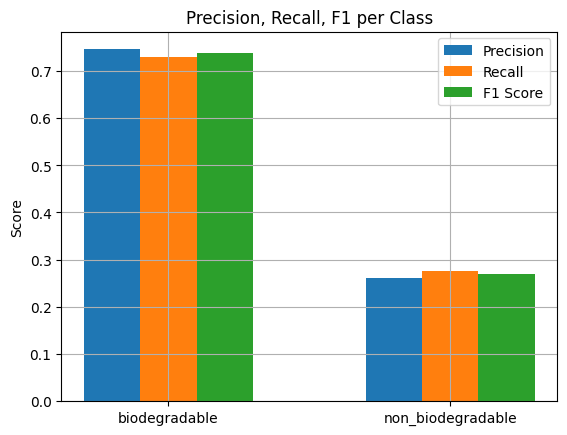

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

x = np.arange(len(class_labels))

plt.bar(x - 0.2, precision, 0.2, label='Precision')
plt.bar(x, recall, 0.2, label='Recall')
plt.bar(x + 0.2, f1, 0.2, label='F1 Score')
plt.xticks(x, class_labels)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 per Class")
plt.legend()
plt.grid(True)
plt.show()


The model is biased toward predicting biodegradable.

Non-biodegradable is underperforming.

UPDATED MODEL

In [ ]:
# 1. Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Set dataset paths (replace with your actual Google Drive path)
train_dir = '/content/drive/MyDrive/WasteClassifier/data/train'
val_dir = '/content/drive/MyDrive/WasteClassifier/data/val'

# 3. Define image size and batch size
img_size = (224, 224)
batch_size = 32

# 4. Data augmentation and preprocessing
train_datagen = ImageDataGenerator(

    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 5. Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)

# 6. Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 7. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 8. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# 9. Plot loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 10. Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# 11. Get predictions and true labels for validation set
val_generator.reset()
y_pred = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

# 12. Classification report
report = classification_report(y_true, y_pred, target_names=['biodegradable', 'non_biodegradable'], output_dict=True)
print(classification_report(y_true, y_pred, target_names=['biodegradable', 'non_biodegradable']))

# 13. Plot precision, recall, F1 per class
labels = ['biodegradable', 'non_biodegradable']
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Precision, Recall, F1 per Class')
plt.legend()
plt.show()

# 14. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
print(tf.__version__)

model.save('waste_classifier.keras')

2.18.0


In [ ]:
from google.colab import files
files.download('waste_classifier.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>